This notebook runs scNym to create an integrated space used in Figures 1 and 2 as well as labeles the unlabeled datasets

## Imports

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData, concat

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
import gc
from upsetplot import plot as UpSet
from itertools import product
import networkx as nx

from scipy.cluster import hierarchy

import re
import h5py

import itertools

In [2]:
import pymn

In [3]:
from scnym.api import scnym_api

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [5]:
# allow tensorboard outputs even though TF2 is installed
# broke the tensorboard/pytorch API
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [6]:
%matplotlib inline

In [7]:
sc.settings.verbosity = 3

## Functions

In [8]:
def plot_umap_studies(adata, studies, **kwargs):
    return sc.pl.umap(adata[adata.obs.study_id.isin(studies)],
               color='study_id',
               groups=studies,
               plotnonfinite=False, **kwargs)    

In [9]:
def move_legend(ax, new_loc, **kws):
    """Seaborn helper function for moving legend becasue currently messed up by default"""
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

## Load Data

In [10]:
dataset_dict = pd.read_csv('/grid/gillis/home/bharris/scNYM/droplet_dataset_dict.csv',index_col=0)
dataset_dict=dataset_dict.apply(np.vectorize(lambda x : '/grid/gillis/data/bharris'+x[13:]))['0'].to_dict()

In [ ]:
datasets = []
for dataset in dataset_dict:
    try:
        print(dataset)
        adata=sc.read_loom(dataset_dict[dataset])
        
        adata.obs['study_id'] = dataset
        datasets.append(adata)
    except:
        print(dataset + ' Not Found')

dahlin
weinreb2
weinreb9


In [ ]:

combined_datasets = datasets[-1].concatenate(datasets[:-1])

combined_datasets_raw = datasets[-1].concatenate(datasets[:-1])

In [22]:
sc.pp.normalize_total(combined_datasets, target_sum=1e6)
sc.pp.log1p(combined_datasets)

normalizing counts per cell
    finished (0:00:01)


In [16]:
combined_datasets.obs.cell_ontology_class.fillna('Unlabeled',inplace=True)
combined_datasets=combined_datasets[combined_datasets.obs.cell_ontology_class !='nan']

In [17]:
# %%time
# scnym_api(adata=combined_datasets,
#           task='train',
#           groupby='cell_ontology_class',
#           out_path='./scnym_output',
#           config={
#               'domain_groupby': 'study_id',
#               'dan_use_conf_pseudolabels': False,
#               'pseudolabel_min_confidence':.9
#           })

CUDA compute device found.
295476 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (8689, 12293)
target   examples:  (295476, 12293)
X:  (8689, 12293)
y:  (8689,)
Using user provided domain labels.
Found 2 source domains and 12 target domains.
Not weighting classes and not balancing classes.
Found 14 unique domains.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...----__________|
Saved best weigh

Trying to set attribute `.uns` of view, copying.


Training complete.

Evaluating model.
EVAL LOSS:  0.21164971962571144
EVAL ACC :  0.9401611047180668
Predictions | Labels
[[ 9  9]
 [ 3  3]
 [24 13]
 [ 2 12]
 [21 21]
 [22 22]
 [ 9  9]
 [ 6  6]
 [12 12]
 [13 13]
 [20 20]
 [12 12]
 [23 23]
 [22 22]
 [ 2  2]]
CPU times: user 4min 50s, sys: 7.22 s, total: 4min 58s
Wall time: 3min 55s


In [18]:
# %%time 
# scnym_api(
#     adata=combined_datasets,
#     task='predict',
#     key_added='scNym',
#     trained_model='./scnym_output',
#     out_path='./scnym_output',
#     config='new_identity_discovery',
# )

CUDA compute device found.


Finding cell types:   0%|          | 1/298 [00:00<00:36,  8.10it/s]

Loaded model predicting 28 classes from 12293 features
['B cell' 'Fraction A pre-pro B cell'
 'Slamf1-negative multipotent progenitor cell'
 'Slamf1-positive multipotent progenitor cell' 'T cell' 'basophil'
 'common lymphoid progenitor' 'early pro-B cell' 'erythroblast'
 'granulocyte' 'granulocyte monocyte progenitor cell'
 'granulocytopoietic cell' 'hematopoietic precursor cell'
 'immature B cell' 'immature NK T cell' 'immature T cell'
 'immature natural killer cell' 'late pro-B cell' 'macrophage'
 'mature natural killer cell' 'megakaryocyte-erythroid progenitor cell'
 'monocyte' 'naive B cell' 'pre-natural killer cell' 'pro-B cell'
 'proerythroblast' 'promonocyte' 'regulatory T cell']
Building a classification matrix...
Gene names match exactly, returning input.
Predicting cell types...


Finding cell types: 100%|██████████| 298/298 [00:34<00:00,  8.53it/s]


Extracting model embeddings...
CPU times: user 1min 18s, sys: 619 ms, total: 1min 19s
Wall time: 1min 19s


In [19]:
combined_datasets.shape

(304165, 12293)

In [20]:
%%time
sc.pp.neighbors(combined_datasets, use_rep='X_scnym', method='rapids')
sc.tl.umap(combined_datasets, min_dist=.4, method='rapids')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:53)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
CPU times: user 19 s, sys: 3.79 s, total: 22.8 s
Wall time: 59.9 s


... storing 'FACS.selection' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'mouse.id' as categorical
... storing 'mouse.sex' as categorical
... storing 'plate.barcode' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'study_id' as categorical
... storing 'exp_groups' as categorical
... storing 'sample' as categorical
... storing 'Cell barcode' as categorical
... storing 'Cell type annotation' as categorical
... storing 'Recipient mouse' as categorical
... storing 'Starting population' as categorical
... storing 'Cell Type' as categorical
... storing 'barcode' as categorical
... storing 'library_id' as categorical
... storing 'seq_run_id' as categorical
... storing 'barcodes' as categorical
... storing 'clusters' as categorical
... storing 'isHSC' as categorical
... storing 'samples' as categorical
... storing 'Amp_

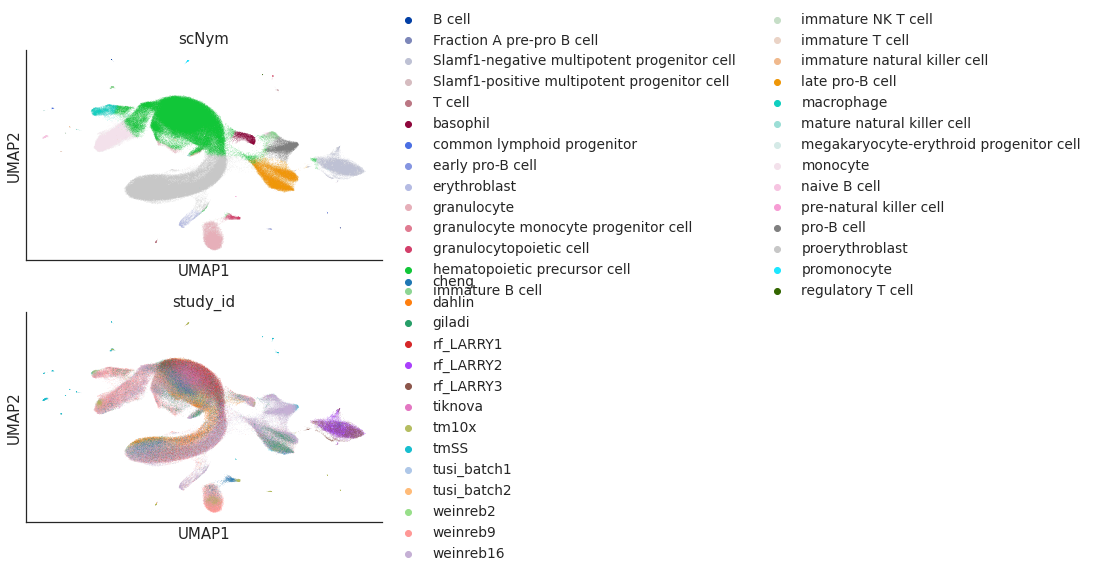

In [21]:
sc.pl.umap(combined_datasets, color=['scNym','study_id'],ncols=1)

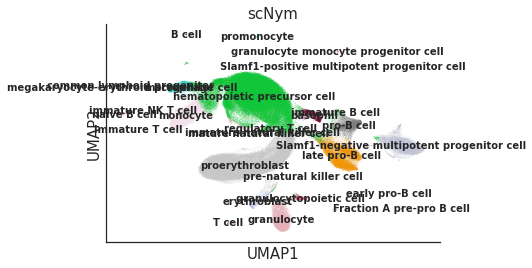

In [41]:
sc.pl.umap(combined_datasets,color='scNym',legend_loc='on data')

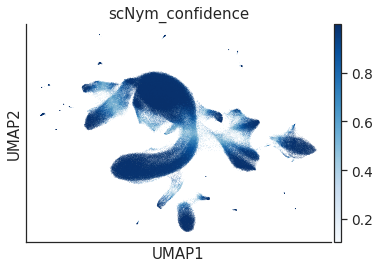

In [103]:
sc.pl.umap(combined_datasets,color='scNym_confidence', color_map='Blues')

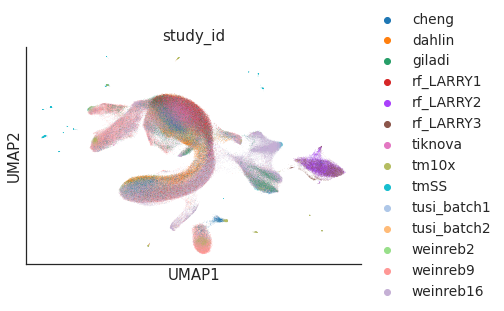

In [102]:
sc.pl.umap(combined_datasets,color='study_id')

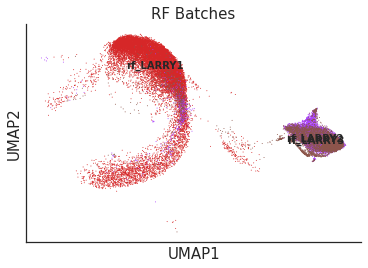

In [96]:
plot_umap_studies(combined_datasets,[i for i in list(dataset_dict.keys()) if 'LARRY' in i], legend_loc='on data',title='RF Batches')

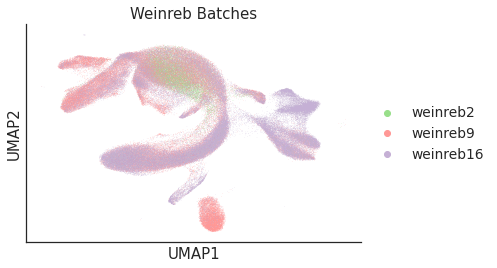

In [97]:
plot_umap_studies(combined_datasets,[i for i in list(dataset_dict.keys()) if 'weinreb' in i], title='Weinreb Batches')

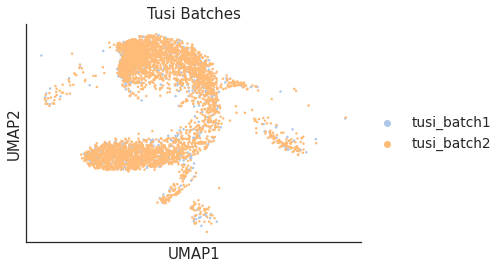

In [98]:
plot_umap_studies(combined_datasets,[i for i in list(dataset_dict.keys()) if 'tusi' in i], alpha_img=.5, title='Tusi Batches')

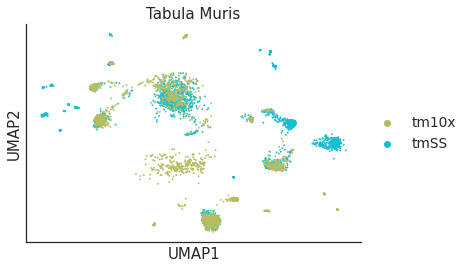

In [99]:
plot_umap_studies(combined_datasets, ['tm10x','tmSS'], title=combined_datasets')

Supplementary Information from the [Tabula Muris paper](https://www.nature.com/articles/s41586-018-0590-4)

Tissue Processing
Isolated bones from forelimbs, hindlimbs, hips, and vertebrae were crushed in FACS
buffer (2% sterile FBS in PBS) on ice, filtered through a 100 µm strainer (Falcon 352360),
pelleted (300 x g, 4oC, 5 minutes), and resuspended in FACS buffer with 100 U/ml DNase I
(Worthington LS006344) and 20 ug/ml Rat-IgG (Abcam ab37361) for 10 minutes on ice. Cells
were incubated with anti-CD117 MicroBeads (Miltenyi Biotec 130-091-224) on ice for 20
minutes, pelleted, resuspended in FACS buffer, and filtered through a 40 µm strainer (Falcon
352340) into an LS column (Miltenyi Biotec 130-042-401). Following magnetic purification, cKit+
cells were eluted, and the flow through was depleted of RBCs with Histopaque-1119 (SigmaAldrich RNBF0417). The c-Kit+
cells and RBC-depleted flow through were resuspended in
FACS buffer with Rat-IgG (20 ug/mL) and incubated on ice for 10 minutes. The flow-through
was stained for B-cells, T-cells, and granulocytes. All antibodies were used at 1:50.
c-Kit+
cells were stained with CD3-FITC (BioLegend 133301, clone 17A2), Ly-6G/Ly6C/GR1-FITC (BioLegend 133301, clone RB6-8C5), CD11B/MAC1-FITC (BioLegend 133301,
clone M1/70), CD45R/B220-FITC (BioLegend 133301, clone RA3-6B2), TER119-FITC
(BioLegend 133301), CKIT-APC (BioLegend 105812, clone 2B8), SCA-1-PECy7 (BioLegend
122514, clone E13-161.7).
B-cells were stained with TER119-PECy5 (BioLegend 116210), B220-FITC (BioLegend
103206, clone RA3-6B2), IgM-PECy7 (BioLegend 406514, clone RMM-1).
T-cells were stained with TER119-PECy5 (BioLegend 116210), CD90/Thy1.1-AF488
(BioLegend 202506, clone OX-7), CD90/Thy1.2-FITC (BioLegend 140304, clone 53-2.1), CD2-
PECy7 (BioLegend 100114, clone RM2-5).
Granulocytes were stained with TER119-PECy5 (BioLegend 116210), CD11B/MAC1-
FITC (BioLegend 101206, clone M1/70), Ly-6G/Ly-6C/GR1-PECy7 (BioLegend 108416, clone
RB6-8C5).
Cells were incubated in antibody for 20 minutes, washed with FACS buffer, and pelleted
(300 x g, 4oC, 5 minutes). After resuspension in FACS buffer, cells were filtered into 35 µm
FACS tubes (Falcon 352235) and stained with 1:1000 SYTOX Blue (ThermoFisher S34857)
immediately prior to sorting.
23
Data Analysis
Bone marrow samples were analyzed as fractionated and unfractionated pools. We used
microfluidic droplets to sequence whole bone marrow cells (depleted of RBCs through Ficoll
separation). For a higher resolution view of the various populations in the bone marrow, we
subfractionated the BM using FACS into five different populations: (1) Lin-Kit+Sca1+ HPCs that
are known to include rarer long-term HSCs and much more abundant short-term multipotent
progenitors (MPPs), (2) Ter119-B220+
cells that include both immature and mature B cells, (3)
Ter119-Cd90+Cd2+
cells that include immature T cells and NK cells, (4) Ter119-Mac1+Gr1Hi cells
that include predominantly granulocytes and (5) TER119-Mac1+Gr1Mid/Lo cells enriched in
monocytes. From both types of analysis, we found the following similarities:
1. From the whole bone marrow, we identified T cells (Ahnak+
, Thy1+
, Cd3e+
, Cd8+
), NK
cells (Kirb1a+
, Kirb1b+
, Kirb1c+
, Ncr1+
), and NKT cells that express both T and NK
gene expression programs. The in-depth view of Ter119-Cd90+Cd2+
cells further
subdivided these populations into immature T cells (Cd3e+
, Cd4+
, Cd8a+
, and Cd6+
),
immature NK cells (Kirb1a+
, Kirb1b+
, Kirb1c+
, Ncr1+
), and immature NKT cells that
express both T and NK cell genes. We also identified a proliferating pre-NK cell
(Mki67+
, Stmn1+
), which may be a precursor to immature NK cells.
2. Both the unfractionated marrow and fractionated marrow yielded four unique
populations. In the whole bone marrow, we find populations similar to early pro-B cells
(Dntt+
, Pax5-
, Rag1+
, Rag2+
) and late pro-B cells (Dntt-
, Pax5+
, Rag1+
, Rag2+
). More
downstream B cells were found that can be further subclustered into immature B cells
(Chchd10+
, Cd79a+
, Cd79b+
, Cd19+
, Ms4a1-/lo, Cd74-
, Mki67+
, Stmn1+
), and mature
(naïve) B cells (Chchd10-
, Cd79a+
, Cd79b+
, Cd19+
, Ms4a1+
, Cd74+
, Mki67-
, Stmn1-
). In
the sorted Ter119-B220+ fraction, we identified a late pro-B cell (Dntt+/-
, Vpreb1+
,
Pax5+
, Rag1+
, Rag2+
, Cd19+
, Cd20-
, Cd22-
), a more downstream intermediate pre-B cell
(Dntt-
, Vpreb1-
, Pax5+
, Rag1+
, Rag2+
, Cd19+
, Chchd10hi, Cd20-
, Cd22-
, Cd74lo), an
immature B cell subset (Dntt-
, Vpreb1-
, Pax5+
, Rag1-
, Rag2-
, Cd19+
, Chchd10hi, Cd20+
,
Cd22+
, Cd74hi) and a more mature (naïve) B cell subset (Dntt-
, Vpreb1-
, Pax5+
, Rag1-
,
Rag2-
, Cd19+
, Chchd10lo, Cd20+
, Cd22+
, Cd74hi). The late-pro B cell could be further
subdivided into Dntt+
, and Dnttlate pro-B cells.
Each approach also generated more nuanced data. From the unfractionated marrow, our analysis
shows the hematopoietic precursor cells (HPCs) (Kit+
, Stmn1+
, Mki67+
) that primarily includes
the HSCs and the early hematopoietic progenitors134
.
1. We identified distinct clusters of proerythroblasts (Beta-s
+
, Hbb-b2+
, Tfrc+
, Mki67+
,
Stmn1+
, Bpgm-
) and erythroblasts (Beta-s
+
, Hbb-b2+
, Tfrc-
, Mki67-
, Stmn1-
, Bpgm+
)
subsets. The proerythroblasts (Beta-s
+
, Hbb-b2+
, Tfrc+
, Mki67+
, Stmn1+
, Bpgm-
) cluster
can be seen diffusing into a subpopulation of downstream, more differentiated
erythroblasts (Beta-s
+
, Hbb-b2+
, Tfrc-
, Mki67-
, Stmn1-
, Bpgm+
).
2. We find proliferating granulopoietic cells (Ltf+
, Pglyrp1+
, Lcn2+
, Camp+
, Mki67+
,
Stmn1+
) downstream of GMPs that are most likely present in the HPC cluster, and
granulocytes (Ltf+
, Pglyrp1+
, Lcn2+
, Camp+
, Mki67-
, Stmn1-
). We also identified a
distinct small cluster of basophils (Ccl3+
, Fcer1a+
, Mcpt8+
) based on our previous
results134
.
3. Proliferating promonocytes (Ahnak+
, Mpeg1+
, Emr1-
, Cd68-
, Mki67+
, Stmn1+
) are also
present, again, downstream of the GMPs that are most likely present in the HPC cluster.
These are transitioning into more mature monocytes (Ahnak+
, Mpeg1+
, Emr1+
, Cd68+
,
Mki67-
, Stmn1-
, Ly6d-
, Irf8lo, Cd74lo) and BM macrophages (Ahnak+
, Mpeg1+
, Emr1+/-
,
Cd68+
, Mki67
-
, Stmn1-
, Ly6d+
, Irf8hi, Cd74hi). We can see a subcluster within the
monocyte cluster that are Cd74hi (indicating the presence of major histocompatibility 
24
complex, class II antigen [MHC-II]), most likely in the process of transitioning to a more
mature bone marrow resident macrophage population.
From subfractionation using FACS, we identified 13 major clusters in our single-cell dataset.
1. The largest group of cells are the HPC clusters (Kit+
, Gpr56+
, Cd34+
) that separated into
multiple subpopulations.
a. Subclustering of HPC cluster: To further analyze transcriptional profile of HPCs,
we gated out clusters characterized by Kit expression. Then, we analyzed cellular
heterogeneity among these cells and distinguished progenitor populations: a
quiescent HSC-enriched fraction (Stmn1-
, Mki67-
, Cd48lo, Flt3lo, Pdzk1ip1hi
,
Ly6ahi), and cells that are immediately downstream of HSCs—the MPPs
(Stmn1+
, Mki67+
, Cd48hi, Flt3hi, Cd34hi). The MPPs could be divided into
Slamf1hi and Slamf1lo populations. Next, we detected more committed fractions
of progenitor cells that express markers corresponding to megakaryocyte
erythrocyte progenitor (MEP) (Tgm2+
, Klf1+
, Treml1+
), and Common
lymphocyte progenitor lineage (CLP) (Dntt+
, Ly6c2+
, Ctsg+
, Tyrobp+
, Cd69+
).
2. Amongst the myeloid cells, we identified one population enriched for granulocytemonocyte progenitors (GMP) (Flt3+
, Kit+
, Mpeg1+
, Itgb2+
, Ahnak+
, Pld4+
, Cd68+
, Hp-
),
and several more mature (Kit-
) downstream populations—monocytes (Cd68+
, Mpeg1+
,
Itgam+
, Emr1+
, Fcgr3+
) and macrophages, which in addition to all monocyte markers
also expressed MHC-II (Cd74hi). Surprisingly, we found the expression of Cd4 on the
cluster identified as macrophages—we have recently shown that infiltrating macrophages
in a tumor tissue can express CD4135. In addition, we identified two different subsets of
granulocytes (Ltf+
, Camp+
, Ngp+
, S100a11Mid
, Pglyrp1+
). One of the granulocyte clusters
is distinct from the majority of other granulocytes and was classified as basophils (Ccl3+
,
Fcer1a+
, Mcpt8+
) based on our previous results134
.
It is important to note for both unfractionated and fractionated analysis, that the HPC cluster
likely contains very few (1-5) true, long-term reconstituting HSCs (LT-HSCs), although they are
not immediately distinguishable136–139. This is likely because (1) cell-surface protein levels and
mRNA expression do not perfectly correlate with the surface markers that are classically used to
identify phenotypic HSCs (e.g. Cd150+
, Cd48-
, Flt3-
, Cd34-
) and therefore, these markers cannot
be reliably used at the transcriptional level to distinguish LT-HSCs from downstream progenitors;
(2) there is a chance of drop out of lowly expressed HSC-specific reporter genes such as Hoxb5,
Fgf5, and Ctnnal1136–138. Additionally, in these datasets, the level of resolution needed to
distinguish LT-HSCs from progenitors may be obscured by the index switching140 of key negative
marker genes across the sequenced pool. It also seems likely that many of the early B, T, NK,
granulocyte, and monocyte progenitors that were captured during the four different sorting
schemes (B, T, Granulocytes, and Monocytes; see above) also clustered with the primary HPC
cluster as this resolution and quality of data was not sufficient to distinguish them for reasons
mentioned earlier. This would explain the presence of MEPs and CLPs in this cluster.
In summary, we were able to generate single cell transcriptomic data for all major cell
populations of bone marrow using two different sequencing approaches. Given the depth of
sequencing and the quality of our data, we were able to identify many immature cell-types that
are in the process of transitioning to a more mature state. We expect these rich datasets will be
valuable in investigating cell-fate decisions during both early myelopoiesis and early
lymphopoiesis.

**The sorting to capture specific populations makes the Tabula Muris a bad dataset for pseudotime, but a good reference since they make sure to captue both progenitors and committed cells**

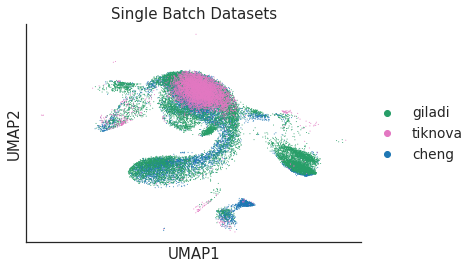

In [100]:
plot_umap_studies(combined_datasets,['giladi','tiknova','cheng'], title='Single Batch Datasets')

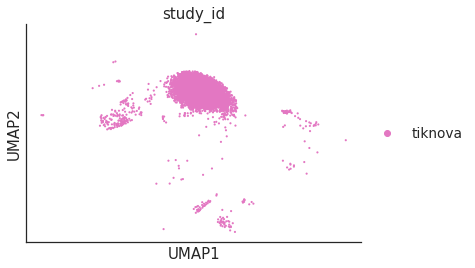

In [101]:
plot_umap_studies(combined_datasets,['tiknova'])

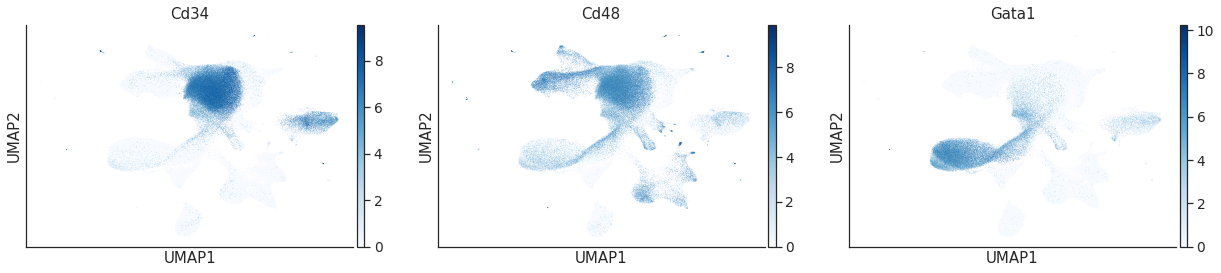

In [22]:
sc.pl.umap(combined_datasets,color=['Cd34','Cd48','Gata1'], color_map='Blues')

In [22]:
cells_by_dataset=pd.get_dummies(combined_datasets.obs[['study_id',
                                                  'scNym']
                                                ].astype(str).set_index('study_id')['scNym']
                          ).reset_index().groupby('study_id').sum()

In [40]:
ncells_in_dataset = 10
nds = 4
selected_cell_types = (cells_by_dataset.drop(['rf_LARRY2','rf_LARRY3', 'tiknova'])>ncells_in_dataset).sum().to_frame().rename({0:'ndatasets'},axis=1).query('ndatasets >=@nds')

In [105]:
combined_datasets.write_loom('unfiltered_combined_droplet_scNym_results.loom', write_obsm_varm=True)

## Filter datasets and cell types

In [42]:
(cells_by_dataset.drop(['rf_LARRY2','rf_LARRY3', 'tiknova'])>ncells_in_dataset).sum().to_frame().rename({0:'ndatasets'},axis=1)

,ndatasets
B cell,1
Fraction A pre-pro B cell,1
Slamf1-negative multipotent progenitor cell,1
Slamf1-positive multipotent progenitor cell,1
T cell,6
basophil,9
common lymphoid progenitor,1
early pro-B cell,1
erythroblast,4
granulocyte,9


In [43]:
selected_cell_types

,ndatasets
T cell,6
basophil,9
erythroblast,4
granulocyte,9
hematopoietic precursor cell,11
immature B cell,4
immature natural killer cell,4
late pro-B cell,10
macrophage,7
monocyte,10


In [44]:
selected_cell_types

,ndatasets
T cell,6
basophil,9
erythroblast,4
granulocyte,9
hematopoietic precursor cell,11
immature B cell,4
immature natural killer cell,4
late pro-B cell,10
macrophage,7
monocyte,10


In [45]:
filtered_combined_datasets= combined_datasets[combined_datasets.obs.scNym.isin(selected_cell_types.index) & 
                                              ~combined_datasets.obs.study_id.isin(['rf_LARRY2','rf_LARRY3','tiknova'])]


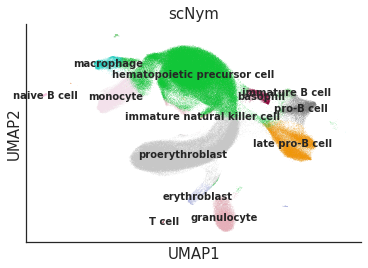

In [46]:
sc.pl.umap(filtered_combined_datasets,color='scNym',legend_loc='on data')

In [48]:
filtered_combined_datasets.shape

(279475, 12293)

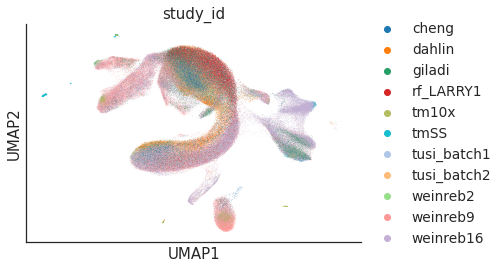

In [47]:
sc.pl.umap(filtered_combined_datasets,color='study_id')

In [35]:
filtered_combined_datasets.shape

(279475, 12293)

In [55]:
cell_type_summaries = pd.concat([filtered_combined_datasets.obs.groupby('scNym_str')['scNym_confidence'].median(),
           filtered_combined_datasets.obs.groupby('scNym_str').size(),n_datasets_filtered],
          axis=1).sort_values('scNym_confidence').rename({'scNym_confidence':'median_confidence', 
                                                          0:'# of Cells'},
                                                         axis=1)
cell_type_summaries

,median_confidence,# of Cells,n_datasets
scNym_str,,,
immature natural killer cell,0.398975,181,7
immature B cell,0.772338,1812,9
macrophage,0.864205,4162,10
pro-B cell,0.893795,8730,7
T cell,0.905415,319,6
erythroblast,0.910809,1902,8
monocyte,0.923420,14358,11
basophil,0.944323,3311,11
late pro-B cell,0.950981,21402,11
